# Preprocess car data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

## Load data

In [2]:
fn = '../data/cars-from-all-auctions.pkl'
print(fn)
car = pd.read_pickle(fn)

../data/cars-from-all-auctions.pkl


## Odometer
convert miles to km and make all numerical

In [3]:
def odo_str2float(df):
    '''
    Convert odometer to numerical values.
    Also convert Miles to KMs.
    '''
    
    ml2km = 1.609344
    
    # substitute to nan
    df.OdoKM = df.OdoKM.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    df.OdoMLS = df.OdoMLS.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    # float
    df["OdoKM_num"] = df.OdoKM.apply(lambda x:x.replace('.','')).astype(float)
    df["OdoMLS_num"] = df.OdoMLS.apply(lambda x:x.replace('.','')).astype(float)
    # convert miles to km
    df["Odo"] = df.OdoKM_num.copy()
    chooseMls = (df.OdoKM_num.isna()) & ~(df.OdoMLS_num.isna())
    df.loc[chooseMls,"Odo"] = df.loc[chooseMls,"OdoMLS_num"].apply(float) * ml2km

In [4]:
# do conversion
odo_str2float(car)
# print new column and source info
car.loc[:,['Odo','OdoKM','OdoKM_num','OdoMLS','OdoMLS_num']]

,Odo,OdoKM,OdoKM_num,OdoMLS,OdoMLS_num
2017-3-2000,23982.000000,23982,23982.0,nan,NaN
2017-3-2001,81459.000000,81459,81459.0,nan,NaN
2017-3-2002,31932.000000,31932,31932.0,nan,NaN
2017-3-2003,84145.000000,84145,84145.0,nan,NaN
2017-3-2004,27248.000000,27248,27248.0,nan,NaN
2017-3-2005,4131.000000,4131,4131.0,nan,NaN
2017-3-2006,79553.000000,79553,79553.0,nan,NaN
2017-3-2007,59227.000000,59227,59227.0,nan,NaN
2017-3-2008,50573.000000,50573,50573.0,nan,NaN
2017-3-2200,103793.000000,103793,103793.0,nan,NaN


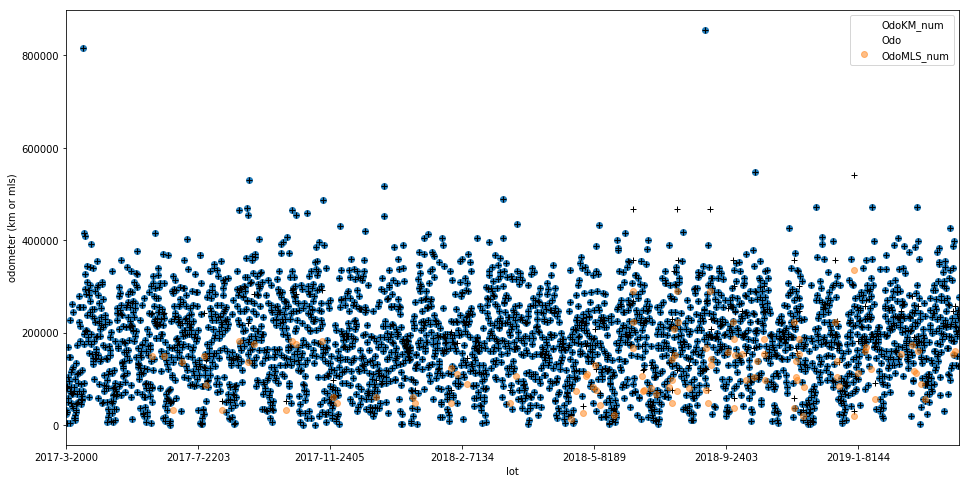

In [5]:
# plot odometer
fig,ax=plt.subplots(figsize=[16,8])
ax.set_xlabel('lot')
ax.set_ylabel('odometer (km or mls)')

car.loc[:,["OdoKM_num"]].plot(marker='o',linestyle='',alpha=1,ax=ax)
car.loc[:,["Odo"]].plot(marker='+',color='k',linestyle='',alpha=1,ax=ax)
car.loc[:,["OdoMLS_num"]].plot(marker='o',linestyle='',alpha=.5,ax=ax)


## Model and brand

Enforce some consistency in naming


In [6]:
# Rename to conventional brand name
car.ItemBrand.replace({
    "ASTON MARTIN":"ASTON-MARTIN",
    'AUTO UNION':'AUDI',
    'JAGUAR CARS':'JAGUAR',
    "MERCEDES BENZ":"MERCEDES-BENZ",
    "MERCEDES":"MERCEDES-BENZ",
    "MICRO COMPACT CAR SMART":"SMART",
},inplace=True)


# When brand name has a specification that needs to go in the model name.
# E.g. Mercedes <AMG> and Audi <QUATTRO>
def add_model_spec(s,spec):
    '''Adds specification at the end of the model name'''
    import re 
    
    # addition should not exist
    if not re.search('(?i)' + spec, s):
        
        # add separator
        if not (s.endswith(';')):
            s += ';'
        # add specification
        s += ' ' + spec
    return s

sel = car.ItemBrand == 'QUATTRO'
car.loc[sel,'ItemType'] = car.loc[sel,'ItemType'].apply(lambda s: add_model_spec(s,'quattro'))
car.loc[sel,'ItemBrand'] = 'AUDI'

sel = car.ItemBrand == 'MERCEDES-AMG'
car.loc[sel,'ItemType'] = car.loc[sel,'ItemType'].apply(lambda s: add_model_spec(s,'amg'))
car.loc[sel,'ItemBrand'] = 'MERCEDES-BENZ'


In [7]:
# unescape special characters
import html
car["model_drz"] = car.ItemType.fillna('').apply(lambda s: html.unescape(s))

# strip brand from model
def remove_brand(model,brand):
    '''remove trailing brand name from model name'''
    
    import re
    
    if type(model) == str:
        model = re.sub('(?i)^' + brand + '[ ,;]*','',model)
    return model 

Type = car.apply(lambda row: remove_brand(row.model_drz,row.ItemBrand),axis='columns')

# special case with accented brand names
sel = car.ItemBrand == 'CITROËN'
Type[sel] = Type[sel].map(lambda x: remove_brand(x,'CITROEN'))
sel = car.ItemBrand == 'JAGUAR CARS'
Type[sel] = Type[sel].map(lambda x: remove_brand(x,'JAGUAR'))

# split extra specifications
Type = Type.fillna('').apply(lambda s: s.split(sep=';'))
# add simple model info back and extra specifications in new field
car["model_drz"] = Type.apply(lambda s: s[0])
car["modelspec_drz"] = Type.apply(lambda s: ''.join(s[1:]).strip(' '))

In [8]:
# Unknown registrations
# Might be able to fix it by looking at the raw text.
ixs = car.loc[car.Reg == 'onbekend'].index
display(car.loc[ixs,['Reg','ForeignReg']])
for ix in ixs:
    print(ix,end='\n\t')
    rt = car.loc[ix,'Raw_text']
    if type(rt) == list:
        print('\n\t'.join(rt))
    else:
        print(rt)

,Reg,ForeignReg
2017-7-8171,onbekend,NaN
2017-11-2609,onbekend,Geen (geldig) Nederlands
2018-5-2413,onbekend,NaN
2018-6-2405,onbekend,NaN


2017-7-8171
	['Type impreza wrx', 'Kenteken onbekend', 'Afgelezen km-stand 104.301', 'Benzine', 'Datum eerste toelating 28.02.1995', 'Voertuig met rechts geplaatst stuurwiel', 'RDW keuring verplicht', 'Zonder kentekenbewijs', 'Certificaat van overeenstemming (CVO) niet aanwezig. Bij registratie/invoer voertuig kan door de RDW om dit certificaat worden gevraagd. Zie onze website, onder vraag en antwoord.', 'Geen (geldig) Nederlands kenteken. Zie artikel 19.4 van de algemene voorwaarden.', 'Kosten voertuigonderzoek buitenlands gekentekende voertuigen RDW EUR 150,00 Zie onze website, onder vraag en antwoord.', 'De kavelomschrijving op de website wordt gemaakt op basis van', 'de bij Domeinen Roerende Zaken bekende gegevens.', 'Domeinen Roerende Zaken is geen garage- of herstelbedrijf en', 'controleert niet of alles naar behoren functioneert.', 'Categorie: Voertuigen en onderdelen']
2017-11-2609
	[Type twingo, Kenteken onbekend, Bouwjaar 2014, Afgelezen km-stand 19.583, Benzine, Zonder kent

In [9]:
# FUTURE: Do something with foreign registrations
# Parsing did not always get it right.
list(car.ForeignReg.unique())


[nan,
 'Brits',
 'Duits',
 'Frans',
 'Belgisch',
 'Bulgaars',
 'Hongaars',
 'Arubaans',
 'Litouws',
 'Estlands',
 'Spaans',
 'Geen (geldig) Nederlands',
 'Het voertuig is voorzien van taxi-kentekenplaten. Taxiregistratie kunt u laten be&#235;indigen via de RDW. Vervanging van de blauwe door gele',
 'Zonder',
 'Vervanging van blauwe door gele',
 'Dit voertuig staat voor export geregistreerd. Voertuig dient voor heractivatie van het originele',
 'Dit voertuig staat voor export geregisteerd. Voertuig dient voor heractivatie van het originele',
 'originele',
 'Het voertuig is voorzien van taxi-kentekenplaten. Taxiregistratie kunt u laten aanpassen via de RDW. Vervanging van blauwe door gele',
 'Iers',
 'Zwitsers',
 'Pools',
 'Amerikaans',
 'Russisch',
 'Roemeens',
 'Italiaans',
 'Luxemburgs',
 'Lets',
 '',
 'Oostenrijks',
 'Nederlands']

## Other repairs

In [10]:
# reparse raw text NAP
# Wrong ones have 'isch'

# re pattern
patt = '^Km-stand volgens nap (?P<val>(logisch)|(onlogisch))$'
# loop over wrong ones
for ix in car[car.NAP == 'isch'].index:
    # line by line
    for line in car.loc[ix,'Raw_text']:
        M = re.match(patt,line)
        if M:
            car.loc[ix,"NAP"] = M.group('val')

## Adhoc repair

When all fails

In [11]:

# '2603 Afkomstig van JFC HQ Brunssum.'
ix='2017-5-2603'
car.loc[ix,"LotNr"] = '2603'

# ix = car.Mfyear[car.Mfyear == 'onbekend']
ix=['2017-4-7127','2017-6-7173']
car.loc[ix,"Mfyear"] = -1

# fix issus with one lot that has no type
# print(car.ItemType[~ (car.ItemType.apply(type) == str)])
# [print(l) for l in eval(car.loc['2017-6-7121','Raw_text'])]
# car.loc['2017-6-7121','Images']
ix = '2017-6-7121'
car.loc[ix,'ItemType'] = 'golf'

# car.loc[car.ItemBrand == 'Kampeerwagen/camper',:]
# car.loc["2017-5-2408",:]
ix = '2017-5-2408'
#car.loc[ix,'ItemBrand'] = 'VOLKSWAGEN'
car.drop(ix,inplace=True) # remove alltogether

# car.loc[car.Mfyear == 'onbekend',:]
ix = '2018-11-2613'
car.loc[ix,'Mfyear'] = pd.np.NaN

# car.loc[car.ItemBrand == 'AUDI A4',:]
ix = '2018-6-7195'
car.loc[ix,'ItemBrand'] = 'AUDI'
car.loc[ix,'ItemType'] = 'a4; ' + car.loc[ix,"ItemType"]

# car.loc[car.ItemBrand == 'MERCDES-BENZ',:]
ix = '2018-9-8162'
car.loc[ix,'ItemBrand'] = 'MERCEDES-BENZ'

# car.loc[car.ItemBrand == 'MINI COOPER',:]
ix = '2018-10-2210'
car.loc[ix,'ItemBrand'] = 'MINI'
car.loc[ix,'ItemType'] = 'cooper; ' + car.loc[ix,"ItemType"]

# car.loc[car.ItemType == 'benz',:]
# car.loc[ix,'Images']
# This is a w204 mfyear < 2011
ix = '2017-5-2618'
car.loc[ix,'ItemType'] = 'c cdi'

# car.loc["2018-1-3046","Raw_text"]
# This is combined lot
car.drop("2018-1-3046",inplace=True) # remove alltogether

# car.ForeignReg=='Het voertuig is voorzien van taxi-kentekenplaten. Taxiregistratie kunt u laten be&#235;indigen via de RDW. Vervanging van de blauwe door gele'
# Taxi
ixs = ['2017-11-8302', '2017-11-8305', '2018-1-8163']
regs = ['54-GLL-5','57-XZ-FV','70-TLF-3']
for ix,reg in zip(ixs,regs):
    car.loc[ix,'taxi'] = True
    car.loc[ix,'Reg'] = reg

# Typo in registration K1900022009
# 8-SKL-15 not 8-SLK-15
ix = '2019-2-2009'
car.loc[ix,'Reg'] = '8-SKL-15'
if car.loc[ix,'rdwinfo']['kenteken'][0] == '8SLK15':
    car.loc[ix,'rdwinfo'] = None

- - - - 
## Make data type consistent

In [12]:
def string_to_list_images(s):
    '''Convert string to list'''
    if type(s) == str:
        s=s.replace('[',"['",1)
        s=s[::-1].replace(']',"]'",1)[::-1]
        s=eval(s.replace(', ',"' , '"))
        
    return s

def string_to_int_lotnr(s):
    '''Convert string to int'''
    if type(s) == str:
        if s[0] == 'K':
            # "K1800092200"
            s=int(s[-4:])
        else:
            s=int(s)
        
    return s

def string_to_list_rawtext(s):
    '''Convert string to list'''
    if type(s) == str:
        if s[1] == "'":
            s=eval(s)
        else:
            s=string_to_list_images(s)
        
    return s

In [13]:
# Convert to the same data type

car.Images = car.Images.apply(lambda r: string_to_list_images(r))
car.LotNr = car.LotNr.apply(string_to_int_lotnr)
car.Raw_text = car.Raw_text.apply(string_to_list_rawtext)

In [14]:
# convert Booleans to 1 / 0

for c in ['automatic','cabriolet','rhd','no_road','taxi','crewcab','carwrap',
          'benzine','diesel','lpg','electric','hybrid',
          'jfc','locked','no_key','no_cvo','no_igk','no_odo','wo_frame','used_parts',
          'import','early_reg','maybe_reg','no_inireg','no_nlreg193','no_nlreg194','no_orireg','no_reg','no_regneeded','no_rdw','rdw150','no_vin',
          'disclaim1','disclaim2','disclaim12','disclaim3','disclaim4','disclaim_cr6']:
    
    car[c] = car[c].replace({0:False,1:True}).fillna(False)

In [15]:
# Get last query from list of rdw querries

last_query = car.rdwinfo.apply(lambda x:pd.to_datetime([i['TimeStamp'] for i in x],format='%Y%m%d').argmax() if type(x) == list else pd.np.NaN)
for queries,last,idx in zip(car.rdwinfo,last_query,car.index):
    if pd.np.isnan(last):
        continue
    car.loc[idx,'rdwinfo'] = [queries[int(last)]]

In [16]:
# Fill empty

car.APKdate = car.APKdate.fillna('')
car.BTW = car.BTW.fillna('')
car.Draw = car.Draw.fillna(False)
car.ForeignReg = car.ForeignReg.fillna('')

car.ItemType = car.ItemType.fillna('')
car.Mfdate = car.Mfdate.fillna('')
car.Mfyear = car.Mfyear.replace('',pd.np.NaN).fillna(0).astype(int)
car.NAP = car.NAP.fillna('')
car.N_images = car.N_images.fillna(-1).astype(int)
car.Note = car.Note.astype(str)
car.Reg = car.Reg.fillna('')
car.Source = car.Source.fillna('')
car.SupInfo = car.SupInfo.fillna('')

In [17]:
# Replace zero price (not sold) with NaN
car.Price = car.Price.replace({0.0:pd.np.NaN})

show data types per column

In [18]:
# print type per column and example values
print('{:>15s}: {:1s} {:<20s} {}\n{}'.format('Column','','Data Type','Values','-'*80))

counter_string = ' +++'
for c in car.columns:
    cnt=-1
    for t in car[c].apply(type).unique():
        cnt+=1
        
        # column name, data type
        print('{:>15s}: {:1s} {:<20s}'.format(c,counter_string[cnt],str(t)),end=' ')
        
        # skip large 
        if c in ['SupInfo','Raw_text','rdwinfo','Images']:
            print('..skip..')
            continue
        
        # values
        v = car[c].unique()
        if len(v) < 10:
            # print all
            print(v)
        else:
            # print first and last
            print('{} .. {}'.format(v[0],v[-1]))


         Column:   Data Type            Values
--------------------------------------------------------------------------------
          LotNr:   <class 'int'>        2000 .. 7264
          Price:   <class 'float'>      54500.0 .. 1790.0
          Title:   <class 'str'>        Kavel 2000 .. Kavel K1900038318
         LotCat:   <class 'str'>        ['Voertuigen en onderdelen' 'Voertuigen en onderdelen ']
        LotType:   <class 'str'>        ['Personenauto']
      ItemBrand:   <class 'str'>        ALFA ROMEO .. DAF
       ItemType:   <class 'str'>        2000 gtv .. 208 cdi
         Mfdate:   <class 'str'>        27.10.1972 .. 23.05.2006
         Mfyear:   <class 'int'>        0 .. 1987
        APKdate:   <class 'str'>         .. 23.08.2019
        benzine:   <class 'bool'>       [ True False]
         diesel:   <class 'bool'>       [False  True]
            lpg:   <class 'bool'>       [False  True]
         hybrid:   <class 'bool'>       [False  True]
       electric:   <class 'bool

## Categorize info from auction

Convert from dummies to categories. Convert different boolean fields into one field with string (reverse one-hot-encode)

In [19]:
# fuel
Fuels = ['lpg','benzine','diesel','hybrid']

# new field
car["fuel_drz"] = str()
# loop over columns
for fuel in pd.np.intersect1d(Fuels,list(car.columns)): # warning: This is case sensitive
    car.loc[car.loc[:,fuel] == True,"fuel_drz"] = fuel


## Date and time operations

Age of car, APK etc.

In [20]:
# Date of auction based on index name
car["now"] = [pd.to_datetime(re.search('([0-9]{4}-[0-9]+)-.*',i)[1],format='%Y-%m') for i in car.index.values]

# APK / Manufacture date / Year
car['apk_drz'] = car.APKdate.apply(lambda t: pd.to_datetime(t,format='%d.%m.%Y') if len(t) != 0 else pd.np.NaN)
car['MF_full_ser'] = car.Mfdate.apply(lambda t: pd.to_datetime(t,format='%d.%m.%Y') if len(t) != 0 else pd.np.NaN)
car['MF_year_ser'] = car.Mfyear.apply(lambda t: pd.to_datetime(t,format='%Y') if t>0 else pd.np.NaN)

# Choose MF year or full date
car["MF_drz"] = car.MF_full_ser.copy()
chooseShort = car.MF_full_ser.isna() & car.MF_year_ser.notna()
car.loc[chooseShort,"MF_drz"] = car.loc[chooseShort,"MF_year_ser"]


- - - -
# Add rdw info into dataframe

### Age of query

Older queries might not have accurate information that was current at auction (e.g. inspection date)

Text(0.5, 1.0, 'Age of rdw query since auction')

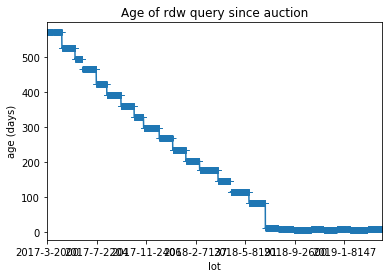

In [21]:
# get time stamp from dict
car['rdw_ser'] = car.rdwinfo.apply(lambda x:pd.to_datetime(x['TimeStamp'],format='%Y%m%d') if type(x)==dict else pd.np.NaN)

# plot query age
car["RDW_age"] = (car["rdw_ser"] - car["now"]).apply(lambda x: x.days)
car["RDW_age"].plot(marker='+')
plt.xlabel('lot')
plt.ylabel('age (days)')
plt.title('Age of rdw query since auction')

Text(0, 0.5, '# entries')

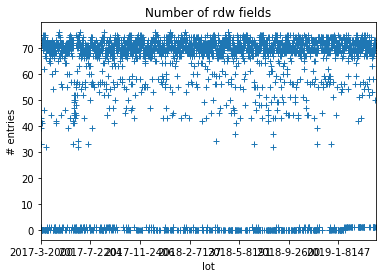

In [22]:
# Nr of rdw entries
car["nRdw"] = car.rdwinfo.apply(lambda x:len(x) if type(x)==dict else 0)

# plot nr of entries
car.loc[:,'nRdw'].plot(marker='+',linestyle='')
plt.xlabel('lot')
plt.title('Number of rdw fields')
plt.ylabel('# entries')

### Rdw info
add as new columns

In [23]:
# Add rdw field to dataframe
#    _<field name> (leading underscore) indicates that this field already existed in the DRZ results and prevents overwriting

Map = {
    "aantal_cilinders": "nCyl",
    "cilinderinhoud": "cylvol",
    "vermogen_massarijklaar": "power",
    "nettomaximumvermogen": "power2",
    "brandstofverbruik_gecombineerd":"milage",
    "aantal_zitplaatsen": "nSeat",
    "aantal_deuren" : "nDoor",
    "breedte": "width",
    "lengte": "length",
    "wielbasis": "wheelbase",
    "massa_ledig_voertuig":"weight",
    "bruto_bpm" : "bpm",
    "catalogusprijs": "newprice",
    "datum_tenaamstelling": "_reglast_str",
    "datum_eerste_afgifte_nederland": "_regnl_str",
    "datum_eerste_toelating": "_regfirst_str",
    "vervaldatum_apk":"_apk_str",
    "type_carrosserie_europese_omschrijving":"_body1",
    "inrichting":"_body2",
    "brandstof_omschrijving":"_fuel",
    "eerste_kleur":"_color",
    "merk":"_brand",
    "handelsbenaming":"_model",
    "taxi_indicator":"_taxi",
}

# has an rdw entry
hasRdw = car.nRdw > 0

# Map rdw info to column in Dataframe
for rdw, column in Map.items():
    
    # new column
    car[column] = None
    
    # has an rdw entry with this key
    # sometimes the field is missing
    hasField = hasRdw.copy()
    hasField[hasField] = car.loc[hasRdw,'rdwinfo'].apply(lambda row: rdw in row.keys())
    
    # map dict key to new field in dataframe
    car.loc[hasField,column] = car.loc[hasField,"rdwinfo"].apply(lambda c:c[rdw][0]) # Take first. Rdw named first key conveniently '0'
    
    # consolidate values if rdw has more than one entry
    if column == "_fuel":
        Values = car.loc[hasField,"rdwinfo"].apply(lambda x:list(x[rdw].values()))
        Order = car.loc[hasField,"rdwinfo"].apply(lambda x:list(x["brandstof_volgnummer"].values()))
        LPG_type = car.loc[hasField,"rdwinfo"].apply(lambda x:x["type_gasinstallatie"][0] if "type_gasinstallatie" in x else "")

        # create a single string for fuel type
        for iV,v in enumerate(Values):
            o = Order[iV]

            # Make zero based index
            o = [oo-1 for oo in o]
            # reorder
            v = [v[oo] for oo in o]
            # join multiple fuels
            Values[iV] = '/'.join(v)
            # if LPG add type
            if ('lpg' in [vv.lower() for vv in v]) & (len(LPG_type[iV]) > 0):
                Values[iV] += '/' + LPG_type[iV]

        # add to new column
        car.loc[hasField,column] = Values


## preprocessing of rdw info

Text(0, 0.5, 'age (year)')

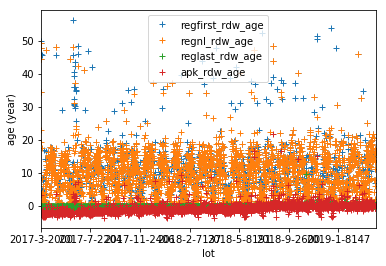

In [24]:
# string to datetime
Map = {
    "_regfirst_str":"regfirst_rdw",
    "_regnl_str":"regnl_rdw",
    "_reglast_str":"reglast_rdw",
    "_apk_str":"apk_rdw",
}

sel_new_format = car.rdwinfo.apply(lambda row: 
                                   pd.to_datetime(row['TimeStamp'], format='%Y%m%d') >= pd.to_datetime('2019-03-01') 
                                   if row else False)
for k, v in Map.items():
    # date
    car[v] = pd.to_datetime('nan')
    car.loc[~sel_new_format,v] = car.loc[~sel_new_format,k].apply(lambda x:pd.to_datetime(x,format="%d/%m/%Y"))
    car.loc[sel_new_format,v] = car.loc[sel_new_format,k].apply(lambda x:pd.to_datetime(x,format="%Y%m%d"))
    # age
    car[v+'_age'] = car.now - car[v]

# remove string values
car.drop(columns=Map.keys(), inplace = True)

# plot
car[[v+'_age' for v in Map.values()]].applymap(lambda x: x.days/365.25).plot(marker='+',linestyle='')
plt.legend()   
plt.xlabel('lot')
plt.ylabel('age (year)')

In [25]:
# same data type
# sometimes type is numerical
car._model = car._model.astype(str)
car._brand = car._brand.astype(str)


In [26]:
# lower case
cols = ['_body1','_body2','_fuel','_model']
car[cols] = car[cols].apply(lambda x: x.str.lower())

In [27]:
# strip brand
car._model = car.apply(lambda row:remove_brand(row._model,row._brand),axis='columns')

# special cases
sel = car._brand == 'JAGUAR CARS'
car.loc[sel,'_model'] = car.loc[sel,:].apply(lambda row:remove_brand(row._model,'JAGUAR'),axis='columns')

### Use auction info or RDW info

In [28]:
# make same string values as rdw
car._body2.replace({'niet geregistreerd':''},inplace = True)
car['taxi_drz'] = car.taxi.replace({False:'Nee',True:'Ja'})


In [29]:
# check if matches

# Pairs to compare
#    Will choose first entry if not equal
fldpairs = [
    ['_taxi','taxi_drz','taxi'],
    ['regfirst_rdw','MF_drz','MF'],
    ['apk_drz','apk_rdw','apk'],
    ['_body1','_body2','bodytype'],
    ['_fuel','fuel_drz','fuel'],
    ['ItemBrand','_brand','brand'],
    ['model_drz','_model','model'],
]

for flds in fldpairs:
    # not empty or nan and different
    isDiff = pd.np.logical_and.reduce((
        ~car[flds[0]].isna(),
        ~car[flds[1]].isna(),
        car[flds[0]] != '',
        car[flds[1]] != '',
        car[flds[0]] != 'nan',
        car[flds[1]] != 'nan',
        car[flds[0]] != car[flds[1]]
    ))
    if '_brand' in flds:
        # RDW can't handel special characters
        isDiff = pd.np.logical_and.reduce((
            isDiff,
#             car[flds[0]] != 'CITROEN',
            car[flds[1]] != 'CITROEN',            
        ))
        
    chooseany = pd.np.logical_and(~car[flds[0]].isna(),~car[flds[1]].isna())
    choosefirst = pd.np.logical_and(~car[flds[0]].isna(),car[flds[1]].isna())
    choosesecond = pd.np.logical_and(car[flds[0]].isna(),~car[flds[1]].isna())
    if ('MF' in flds) or ('apk' in flds):
        car[flds[2]] = pd.to_datetime('NaN')
    else:
        car[flds[2]] = 'NaN'

    car.loc[chooseany | choosefirst,flds[2]] = car.loc[chooseany | choosefirst,flds[0]]
    car.loc[choosesecond,flds[2]] = car.loc[choosesecond,flds[1]]

    if all(~isDiff):
        print('ok')
    else:
        if 'model' in flds:
            display(car.loc[isDiff,['brand','_brand']+flds])
        else:
            display(car.loc[isDiff,flds])


,_taxi,taxi_drz,taxi
2017-3-8109,Ja,Nee,Ja
2017-4-7106,Ja,Nee,Ja
2017-6-2013,Ja,Nee,Ja
2017-6-7110,Ja,Nee,Ja
2017-7-8129,Ja,Nee,Ja
2017-8-2007,Ja,Nee,Ja
2017-9-2624,Ja,Nee,Ja
2017-10-7123,Ja,Nee,Ja
2017-10-7142,Ja,Nee,Ja
2017-10-7171,Ja,Nee,Ja


,regfirst_rdw,MF_drz,MF
2018-3-2602,2009-07-03,2011-03-01,2009-07-03


,apk_drz,apk_rdw,apk
2017-3-2200,2018-03-28,2020-03-29,2018-03-28
2017-3-2208,2017-03-04,2019-03-23,2017-03-04
2017-3-2211,2017-06-06,2019-06-06,2017-06-06
2017-3-2212,2017-08-15,2019-09-28,2017-08-15
2017-3-2214,2018-04-29,2020-04-29,2018-04-29
2017-3-2215,2018-08-02,2020-08-02,2018-08-02
2017-3-2217,2017-11-21,2018-11-21,2017-11-21
2017-3-2218,2017-06-30,2019-07-04,2017-06-30
2017-3-2220,2017-03-20,2019-05-03,2017-03-20
2017-3-2221,2017-06-05,2019-06-05,2017-06-05


,_body1,_body2,bodytype
2017-6-2214,vrachtwagen,open wagen,vrachtwagen
2017-7-2209,vrachtwagen,open wagen,vrachtwagen
2017-7-2210,vrachtwagen,voor vervoer voertuigen,vrachtwagen
2018-6-2204,sedan,limousine,sedan


,_fuel,fuel_drz,fuel
2017-3-8166,benzine/lpg/g3 gasinstallatie,lpg,benzine/lpg/g3 gasinstallatie
2017-3-8181,benzine/lpg/g3 gasinstallatie,lpg,benzine/lpg/g3 gasinstallatie
2017-4-2209,benzine/lpg/g3 gasinstallatie,lpg,benzine/lpg/g3 gasinstallatie
2017-4-7104,benzine/lpg/g3 gasinstallatie,lpg,benzine/lpg/g3 gasinstallatie
2017-4-7183,benzine/lpg/g3 gasinstallatie,lpg,benzine/lpg/g3 gasinstallatie
2017-5-8000,lpg/g2 gasinstallatie,lpg,lpg/g2 gasinstallatie
2017-5-8001,lpg/g2 gasinstallatie,lpg,lpg/g2 gasinstallatie
2017-5-8002,benzine/lpg/g2 gasinstallatie,lpg,benzine/lpg/g2 gasinstallatie
2017-5-8005,benzine,lpg,benzine
2017-5-8006,lpg/g2 gasinstallatie,lpg,lpg/g2 gasinstallatie


,ItemBrand,_brand,brand
2017-3-2003,VOLKSWAGEN,None,VOLKSWAGEN
2017-3-2007,VOLKSWAGEN,None,VOLKSWAGEN
2017-3-2201,AUDI,None,AUDI
2017-3-2203,FORD,None,FORD
2017-3-2204,BMW,None,BMW
2017-3-2213,RENAULT,None,RENAULT
2017-3-2401,MERCEDES-BENZ,None,MERCEDES-BENZ
2017-3-2409,VOLKSWAGEN,None,VOLKSWAGEN
2017-3-2415,AUDI,None,AUDI
2017-3-2601,MAZDA,None,MAZDA


,brand,_brand,model_drz,_model,model
2017-3-2408,AUDI,AUDI,SQ5 tdi,sq5 tdi,SQ5 tdi
2017-3-8311,RENAULT,RENAULT,megane grand tour 1.5 dci 63kw,megane grand tour 1.5 dci 63kw van e4,megane grand tour 1.5 dci 63kw
2017-3-8318,OPEL,OPEL,combo-c-van z13dtj-dpf/2000-h,combo-c-van z13dtj-dpf/2000-h ac,combo-c-van z13dtj-dpf/2000-h
2017-4-2406,AUDI,QUATTRO,q7,audi q7,q7
2017-4-2409,AUDI,AUDI,a5,a5 cabriolet,a5
2017-5-2406,MERCEDES-BENZ,MERCEDES-BENZ,S600 Maybach,s 600 maybach,S600 Maybach
2017-5-2407,AUDI,QUATTRO,rs6,audi rs6,rs6
2017-6-2208,AUDI,QUATTRO,rs4,audi rs4,rs4
2017-8-2202,FIAT,FIAT,500 t-jet abarth competizione,500 abarth,500 t-jet abarth competizione
2017-8-7116,AUDI,AUTO UNION,coupe 128 kw u9,audi coupe 128 kw u9,coupe 128 kw u9


In [30]:
# convert back to boolean
car.taxi.replace({'Nee':False,'Ja':True}, inplace = True)

- - - - 
# calculate extra info

Text(0, 0.5, 'age (days)')

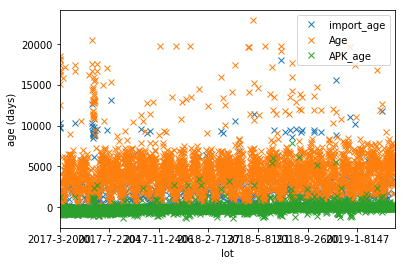

In [31]:
car["Age"] =  (car["now"] - car["MF"]).apply(lambda x: x.days)
car["APK_age"] = (car["now"] - car["apk"]).apply(lambda x: x.days)
car["import_age"] = (car["regnl_rdw"] - car["regfirst_rdw"]).apply(lambda x: x.days)

# plot results
car.loc[:,["import_age","Age","APK_age"]].plot(marker='x',linestyle='')
plt.xlabel('lot')
plt.ylabel('age (days)')

- - - - 
# subselection and save

In [32]:
print('Columns in Dataframe')
for i,c in enumerate(car.columns):
    if i%4 == 0:
        print('')
    print('{:20s}'.format(c), end = '')


Columns in Dataframe

LotNr               Price               Title               LotCat              
LotType             ItemBrand           ItemType            Mfdate              
Mfyear              APKdate             benzine             diesel              
lpg                 hybrid              electric            automatic           
cabriolet           OdoKM               OdoMLS              OpH                 
NAP                 Reg                 ForeignReg          import              
jfc                 maybe_reg           no_cvo              no_igk              
no_inireg           no_key              no_nlreg193         no_nlreg194         
no_odo              no_orireg           no_rdw              no_reg              
no_regneeded        no_road             rdw150              rhd                 
taxi                BTW                 disclaim1           disclaim2           
disclaim3           disclaim4           Draw                SupInfo             
Note  

### Save data for ML

In [33]:
out = car.loc[:,
             ["Price",
              "brand",
              "model",
              "Age",
              "fuel",
              "Odo",
              "APK_age",
              "import_age",
              "bodytype",
              "cylvol",
              "nCyl",
              "power",
              "power2",
              "weight",
              "bpm",
              "newprice",
              "nSeat",
              "nDoor", 
              "_color"
             ]].rename(columns={
    'Price':'price',
    'Age':'age',
    'Odo':'odometer',
    'APK_age':'days_since_inspection_invalid',
    'import_age':'age_at_import',
    'bodytype':'body_type',
    'cylvol':'displacement',
    'nCyl':'number_of_cylinders',
    'bpm':'registration_tax',
    'newprice':'sale_price',
    'nSeat':'number_of_seats',
    'nDoor':'number_of_doors',
    '_color':'color',
})
out.tail()

,price,brand,model,age,fuel,odometer,days_since_inspection_invalid,age_at_import,body_type,displacement,number_of_cylinders,power,power2,weight,registration_tax,sale_price,number_of_seats,number_of_doors,color
2019-3-8211,921.0,PEUGEOT,206,6034.0,benzine,205669.0,-175.0,0.0,cabriolet,1997,4,0.08,100,1127,5668,None,4,2,GRIJS
2019-3-8212,4573.0,VOLKSWAGEN,polo,2556.0,benzine,128318.0,26.0,1794.0,hatchback,1197,4,0.06,66,1002,360,15875,5,4,ZWART
2019-3-8214,NaN,BMW,530d,4665.0,diesel,249866.0,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None
2019-3-8215,1186.0,BMW,530d,5357.0,diesel,232298.0,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None
2019-3-8318,1250.0,MERCEDES-BENZ,208 cdi,5953.0,diesel,277933.0,226.0,0.0,mpv,2148,4,0.03,60,1765,10590,None,9,3,WIT


In [34]:
# save data
fn = '../data/cars-for-ml.pkl'
print(fn)
out.to_pickle(fn)

../data/cars-for-ml.pkl


### Save data for image classification

In [35]:
out = car.loc[:,
             ["Images",
              "brand",
              "model",
              "modelspec_drz",
              "_color",
              "Age",
              "bodytype",
              "cabriolet",
              "nDoor", 
              "length", 
              "wheelbase",
              "ForeignReg",
              "Reg",
              "taxi",
             ]].rename(columns={
    'Images':'image_urls',
    'modelspec_drz':'model_specification',
    '_color':'color',
    'Age':'age',
    'bodytype':'body_type',
    'cabriolet':'convertible',
    'nDoor':'number_of_doors',
    'ForeignReg':'foreign_registration',
    'Reg':'registration_number'
})
out.tail()

,image_urls,brand,model,model_specification,color,age,body_type,convertible,number_of_doors,length,wheelbase,foreign_registration,registration_number,taxi
2019-3-8211,[http://www.domeinenrz.nl/ufc/static/155126098...,PEUGEOT,206,cc 2.0 16v,GRIJS,6034.0,cabriolet,True,2,384,244,,87-JT-FD,False
2019-3-8212,[http://www.domeinenrz.nl/ufc/static/155126098...,VOLKSWAGEN,polo,,ZWART,2556.0,hatchback,False,4,0,246,,NG-850-Z,False
2019-3-8214,[http://www.domeinenrz.nl/ufc/static/155126098...,BMW,530d,,None,4665.0,NaN,False,None,None,None,Duits,,False
2019-3-8215,[http://www.domeinenrz.nl/ufc/static/155126099...,BMW,530d,,None,5357.0,NaN,False,None,None,None,Brits,,False
2019-3-8318,[http://www.domeinenrz.nl/ufc/static/155126098...,MERCEDES-BENZ,208 cdi,,WIT,5953.0,mpv,False,3,490,300,,46-LD-DD,True


In [36]:
# save data
fn = '../data/cars-for-imageclf.pkl'
print(fn)
out.to_pickle(fn)

../data/cars-for-imageclf.pkl


# Write example table to file
based on: https://stackoverflow.com/a/33869154

In [37]:
def pandas_df_to_markdown_table(df):
    fmt = ['-----' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return df_formatted.to_csv(sep="|", index=False)


In [38]:
fn = '../data/cars-for-ml.pkl'
print(fn)
out = pd.read_pickle(fn)

fn = '../assets/example-table-of-ml.md'
example = out.tail(10).copy()
# trim some long fields
example.rdwinfo = '.. rdw info ..'
example.Raw_text = '.. raw text ..'
example.SupInfo = '.. suplm. info. ..'
table_text = pandas_df_to_markdown_table(example.reset_index())
with open(fn,'w') as file:
    file.write(table_text)
    
print('A markdown table is available as\n\t{}'.format(fn))

../data/cars-for-ml.pkl
A markdown table is available as
	../assets/example-table-of-ml.md


In [39]:
fn = '../data/cars-for-imageclf.pkl'
print(fn)
out = pd.read_pickle(fn)

fn = '../assets/example-table-of-imageclf.md'
example = out.tail(10).copy()
# trim some long fields
example.rdwinfo = '.. rdw info ..'
example.Raw_text = '.. raw text ..'
example.SupInfo = '.. suplm. info. ..'
table_text = pandas_df_to_markdown_table(example.reset_index())
with open(fn,'w') as file:
    file.write(table_text)
    
print('A markdown table is available as\n\t{}'.format(fn))

../data/cars-for-imageclf.pkl
A markdown table is available as
	../assets/example-table-of-imageclf.md
